<a href="https://colab.research.google.com/github/constantinpape/dl-teaching-resources/blob/main/exercises/classification/3_multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer Perceptron on CIFAR10

Based on the previous exercise, we will train a multi-layer network, also known as multi-layer perceptron. In this architecture, we will have 'hidden layers', i.e. layers that receive input not from the input directly but from previous layers in the network and that are not directly observed in the output.

## Downloading the data - BAND

Data used in webinars is already downloaded and can be found in `/scratch/dl-course-data`

In [1]:
cifar_dir = "/scratch/dl-course-data/webinar2/cifar10"

## Downloading the data - Colab 

In [ ]:
cifar_dir = './cifar10'

In [ ]:
!cifar2png cifar10 {cifar_dir}

In [ ]:
# we refactor some codes from previous notebooks into a python file 'utils.py'
# to reuse it in later notebooks.
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/dl-teaching-resources/main/exercises/classification/utils.py

## Preperation

In [2]:
# load tensorboard extension
%load_ext tensorboard

In [3]:
# import torch and other libraries
import os
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

/opt/conda/envs/dl-pytorch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# check if we have gpu support
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is available


In [5]:
# we will reuse the training function, validation function and
# data preparation from the previous notebook
import utils

In [6]:
categories = os.listdir(os.path.join(cifar_dir, 'train'))
categories.sort()

## Multi-layer perceptron

In this execise, we go from a single layer network to a network with multiple layers, also known as multi-layer perceptron, or MLP.
We still use fully connected layers (`nn.Linear`), i.e. each neuron in a given layer receives input from all neurons in the previous layer.

Imporantly, we apply a non-linearity to all layer outputs.
Otherwise, the layers could be collapsed into a single layer by matrix multiplication.

In [7]:
class MLP(nn.Module):
    def __init__(self, n_pixels, n_classes):
        super().__init__()
        self.n_pixels = n_pixels
        self.n_classes = n_classes
        
        # here, we define the structure of the MLP.
        # it's imporant that we use a non-linearity after each 
        # fully connected layer! Here we use the rectified linear
        # unit, short ReLu
        self.layers = nn.Sequential(
            nn.Linear(n_pixels, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.view(-1, self.n_pixels)
        x = self.layers(x)
        return x

In [8]:
# instantiate the model
model = MLP(3072, 10)
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=10, bias=True)
    (9): LogSoftmax(dim=1)
  )
)

In [9]:
# get training and validation data
train_dataset, val_dataset = utils.make_cifar_datasets(cifar_dir)

100%|██████████| 10/10 [01:50<00:00, 11.03s/it]


In [10]:
# instantiate loaders, loss, optimizer and tensorboard

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=25)

optimizer = Adam(model.parameters(), lr=1.e-4)

loss_function = nn.NLLLoss()
loss_function.to(device)

In [13]:
tb_logger = SummaryWriter('runs/log_mlp')
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 20850), started 0:30:59 ago. (Use '!kill 20850' to kill it.)

In [11]:
# train for a couple of epochs
n_epochs = 6
for epoch in trange(n_epochs):
    utils.train(model, train_loader, loss_function, optimizer,
                device, epoch, tb_logger=tb_logger)
    step = (epoch + 1) * len(train_loader)
    utils.validate(model, val_loader, loss_function,
                   device, step,
                   tb_logger=tb_logger)

100%|██████████| 6/6 [03:36<00:00, 36.12s/it]


In [12]:
# evaluate the model on test data
test_dataset = utils.make_cifar_test_dataset(cifar_dir)
test_loader = DataLoader(test_dataset, batch_size=25)
predictions, labels = utils.validate(model, test_loader, loss_function,
                                     device, step=0, tb_logger=None)

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


Test accuracy:
0.4709


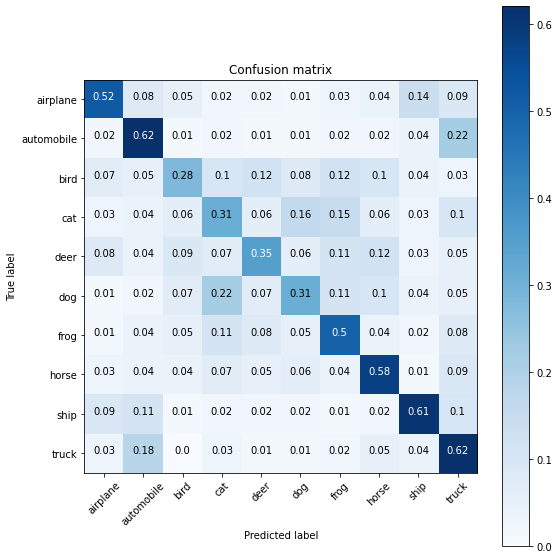

In [14]:
import matplotlib.pyplot as plt
print("Test accuracy:")
accuracy = metrics.accuracy_score(labels, predictions)
print(accuracy)

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(labels, predictions, categories, ax)

In [15]:
# QUESTION: sometimes I can't see the tensorboard dashboard in the notebook.
# How to get it back?

## Tasks and Questions

Tasks
- Try 3 different learning rate values and observe how this changes the training curves, training time and results on the test data.
- Try different architectures for your MLP. For example, you can increase the number of layers or use a different activation function (e.g. Sigmoid) and compare them on the test dataset.

Question:
- Which of the models you have trained in this and in the previous notebook perform best?
- Besides the final performance, how do the training curves differ?
- Can you find any systematic similarities or differences in the confusion matrix for the different models?
- What can you do to make the results of these comparisons more reliable?

Advanced:
- Try one or more of your architectures with preset filters (see last notebook) as input features.